In [88]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for number crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns

/kaggle/input/telco-customer-churn-ibm-dataset/Telco_customer_churn.xlsx


In [89]:
os.listdir('/kaggle/input/telco-customer-churn-ibm-dataset')

['Telco_customer_churn.xlsx']

In [90]:
data = pd.read_excel('/kaggle/input/telco-customer-churn-ibm-dataset/Telco_customer_churn.xlsx')

data.head(5)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


# Dropping the columns that wont be used

In [91]:
data.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

In [92]:
data.drop(labels=['CustomerID','Count','Country','State','City','Zip Code','Lat Long','Latitude','Longitude','Churn Reason', 'Churn Label'], inplace=True, axis=1)

In [93]:
data.columns

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Value',
       'Churn Score', 'CLTV'],
      dtype='object')

In [94]:
data.head(5)

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV
0,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,86,3239
1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,67,2701
2,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1,86,5372
3,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1,84,5003
4,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1,89,5340


# CLV Distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


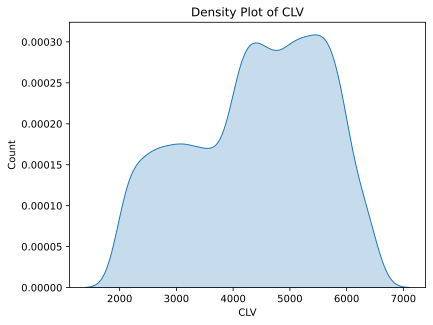

In [95]:
# Plotting CLV using a Kernell Density Estimation to see its distribution
sns.kdeplot(data['CLTV'], fill=True)

plt.xlabel("CLV")
plt.ylabel("Count")
plt.title("Density Plot of CLV")
plt.show()

# Data processing

In [96]:
# Replacing YES/NO booleans with 1/0
boolCols = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']
data[boolCols] = data[boolCols].replace({"Yes":1, "No":0})

# Replacing classes with numerical values
classCols = ['Gender', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Payment Method']
le = LabelEncoder()

for col in classCols:
    data[col]= le.fit_transform(data[col])

data.head(5)

/tmp/ipykernel_47/180100237.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[boolCols] = data[boolCols].replace({"Yes":1, "No":0})


,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV
0,1,0,0,0,2,1,0,0,2,2,...,0,0,0,1,3,53.85,108.15,1,86,3239
1,0,0,0,1,2,1,0,1,0,0,...,0,0,0,1,2,70.70,151.65,1,67,2701
2,0,0,0,1,8,1,2,1,0,0,...,2,2,0,1,2,99.65,820.5,1,86,5372
3,0,0,1,1,28,1,2,1,0,0,...,2,2,0,1,2,104.80,3046.05,1,84,5003
4,1,0,0,1,49,1,2,1,0,2,...,2,2,0,1,0,103.70,5036.3,1,89,5340


In [107]:
# z-score of numerical data! (Except Churn and CLV)
cols2zscore = ['Tenure Months', 'Monthly Charges', 'Total Charges']

#z-score
for col in cols2zscore:
    data[col] = pd.to_numeric(data[col])
    meanval = np.mean(data[col])
    stdev = np.std(data[col], ddof=1)
    data[col] = (data[col]-meanval) / stdev

data.head(5)

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV
0,1,0,0,0,-1.236636,1,0,0,2,2,...,0,0,0,1,1.334768,-0.362635,-0.959581,1,86,3239
1,0,0,0,1,-1.236636,1,0,1,0,0,...,0,0,0,1,0.398529,0.197351,-0.940391,1,67,2701
2,0,0,0,1,-0.992332,1,2,1,0,0,...,2,2,0,1,0.398529,1.159463,-0.645323,1,86,5372
3,0,0,1,1,-0.177982,1,2,1,0,0,...,2,2,0,1,0.398529,1.330616,0.336492,1,84,5003
4,1,0,0,1,0.677085,1,2,1,0,2,...,2,2,0,1,-1.473947,1.294059,1.214503,1,89,5340


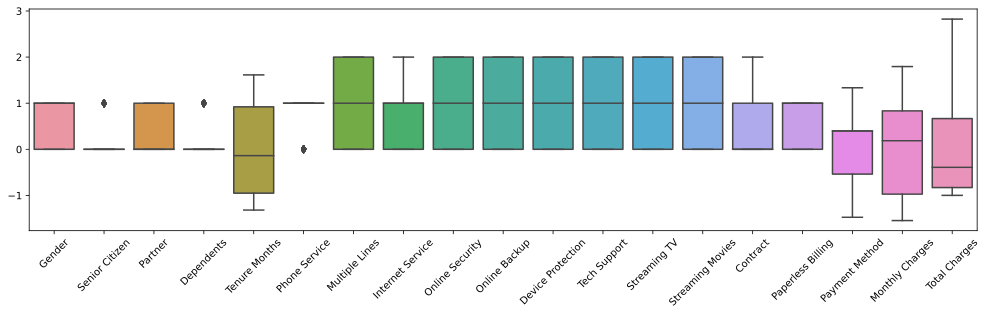

In [108]:
# check the new distribution
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data.drop(columns=['Churn Value', 'Churn Score', 'CLTV']))
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()
     